In [3]:
%load_ext autoreload
%autoreload 2

import sys
if ".." not in sys.path:
    sys.path.insert(0, "..")

import numpy as np
import cv2
import json
from pathlib import Path
import matplotlib.pyplot as plt
from dataclasses import dataclass

from calib_utils import *

DATA_ROOT = Path("../../data")

In [10]:
# Load config and map
config_file = Path(DATA_ROOT/"config.json")
with config_file.open() as f:
    config = json.load(f)

map_file = Path(config["map"]["image"])
im_map = imread_rgb(DATA_ROOT/map_file)

T_map_from_world2 = np.array(config["map"]["T_map_from_world2"])
T_world2_from_map = np.linalg.inv(T_map_from_world2)

In [6]:
# Load constraints
import yaml
with Path("camera_constraints.yaml").open() as f:
    constraints_data = yaml.safe_load(f)
constraints_data

{'floor_constraints': {'Kamera 01': {'image': [[558, 470],
    [502, 236],
    [769, 245],
    [861, 249],
    [1295, 277],
    [1353, 283],
    [1565, 358],
    [1708, 388],
    [1259, 732],
    [1615, 965]],
   'world': [[-88.52985154, 54.58961867, 0.0],
    [-73.31822199, 55.5207104, 0.0],
    [-75.97108503, 48.97485339, 0.0],
    [-76.62018982, 46.85873582, 0.0],
    [-77.97484329, 35.20598175, 0.0],
    [-78.05950913, 33.14629398, 0.0],
    [-84.04256194, 30.40944859, 0.0],
    [-85.42543735, 25.21790683, 0.0],
    [-94.96445551, 48.94663849, 0.0],
    [-98.85908422, 48.04376166, 0.0]]},
  'ZAG-ELP-CAM-017': {'image': [[1275, 916],
    [1458, 904],
    [1817, 874],
    [1894, 937],
    [1954, 996],
    [1811, 1204],
    [2198, 1293],
    [1080, 1031],
    [1047, 1115]],
   'world': [[-58.89680697, 42.14684737, 0.0],
    [-61.40856027, 42.90864969, 0.0],
    [-67.2222814, 44.77083315, 0.0],
    [-64.37186473, 48.10019146, 0.0],
    [-63.01721126, 49.76487061, 0.0],
    [-57.9937046

Number of points in:
  submap corners=2
  floor_polygon=17
  world=9
  image=9


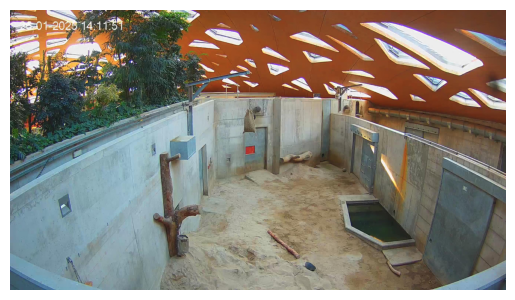

In [14]:
#######################################
# This is the camera we are calibrating
# camera_name = "Kamera 01"
camera_name = "ZAG-ELP-CAM-017"
########################################

submap_corners_in_map = np.array(constraints_data["submap_corners"].get(camera_name, None))
floor_polygon_in_camera = np.array(constraints_data["floor_polygons"].get(camera_name, None))

camera_constraints = constraints_data["floor_constraints"].get(camera_name, None)
constraint_points_in_world = np.array(camera_constraints["world"] if camera_constraints else None)
constraint_points_in_image = np.array(camera_constraints["image"] if camera_constraints else None)

print(f"Number of points in:")
print(f"  submap corners={submap_corners_in_map.shape[0]}")
print(f"  floor_polygon={floor_polygon_in_camera.shape[0]}")
print(f"  world={constraint_points_in_world.shape[0]}")
print(f"  image={constraint_points_in_image.shape[0]}")

files = list(DATA_ROOT.glob(f"cameras/{camera_name}/*.jpg"))
assert len(files)>0, "No image files found in camera dir. Need a sample image."
image_filename = files[0].relative_to(DATA_ROOT)

im_camera = imread_rgb(DATA_ROOT / image_filename)
height, width, _ = im_camera.shape
plt.imshow(im_camera)
plt.gca().set_axis_off()

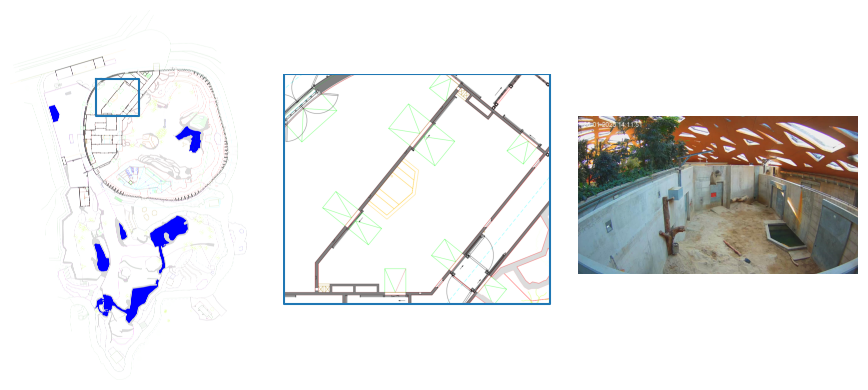

In [33]:
######################################
# Show submap
im_submap = im_map[submap_corners_in_map[0,1] : submap_corners_in_map[1,1], submap_corners_in_map[0,0] : submap_corners_in_map[1,0], :]

T_submap_from_map = np.array([[1,0,-submap_corners_in_map[0,0]],[0,1,-submap_corners_in_map[0,1]],[0,0,1]])
T_submap_from_world2 = T_submap_from_map @ T_map_from_world2
T_world2_from_submap = np.linalg.inv(T_submap_from_world2)

submap_corners_in_world2 = hmult(T_world2_from_map, submap_corners_in_map)
submap_corners_in_submap = hmult(T_submap_from_world2, submap_corners_in_world2)

def plot_rectangle_xyxy(ax, points):
    x0, y0 = points[0, 0:2]
    x1, y1 = points[1, 0:2]
    ax.plot([x0, x0, x1, x1, x0], [y0, y1, y1, y0, y0], "-")

fig, axs = plt.subplots(1, 3, figsize=(9, 4))
axs[0].imshow(im_map)
plot_rectangle_xyxy(axs[0], submap_corners_in_map)
axs[1].imshow(im_submap)
plot_rectangle_xyxy(axs[1], submap_corners_in_submap)
axs[2].imshow(im_camera)
for ax in axs:
    ax.set_axis_off()
fig.tight_layout()

In [16]:
constraint_points_in_world2 = constraint_points_in_world[:,0:2]
constraint_points_in_submap = hmult(T_submap_from_world2, constraint_points_in_world2)


In [29]:
def plot_projections(H_camera_from_world2:np.ndarray, undistort= lambda x:x, distort=lambda x:x):
    H_world2_from_camera = np.linalg.inv(H_camera_from_world2)
    H_submap_from_camera = T_submap_from_world2 @H_world2_from_camera

    points_in_image =  constraint_points_in_image
    points_in_world2 =  constraint_points_in_world2

    floor_polygon_in_submap = hmult(H_submap_from_camera, undistort(floor_polygon_in_camera))
    submap_points = hmult(T_submap_from_world2, points_in_world2)
    camera_points_exp = distort(hmult(H_camera_from_world2, points_in_world2))
    world2_points_exp = hmult(H_world2_from_camera, undistort(points_in_image))
    submap_points_exp = hmult(T_submap_from_world2, points_in_world2)

    errors = np.linalg.norm(submap_points - submap_points_exp, axis=1)
    print(f"Error (submap units): mean={np.mean(errors)}, max={np.max(errors)}, sum={np.sum(errors)}")

    errors = np.linalg.norm(points_in_world2  - world2_points_exp, axis=1)
    print(f"Error (world units): mean={np.mean(errors)}, max={np.max(errors)}, sum={np.sum(errors)}")

    errors = np.linalg.norm(points_in_image -  points_in_image, axis=1)
    print(f"Error (camera units): mean={np.mean(errors)}, max={np.max(errors)}, sum={np.sum(errors)}")

    fig,axs = plt.subplots(1,2,figsize=(20,15))
    axs[0].imshow(im_submap)
    axs[1].imshow(im_camera)
    ax = axs[0]
    ax.plot(floor_polygon_in_submap[:,0],floor_polygon_in_submap[:,1],"-",color="purple")
    ax = axs[1]
    ax.plot(floor_polygon_in_camera[:,0],floor_polygon_in_camera[:,1],"-",color="lightgreen")
    for i in range(points_in_image.shape[0]):
        ax = axs[0]
        ax.plot(submap_points[i,0],submap_points[i,1],"*",markersize=20, color="lightgreen",alpha=0.5)
        ax.plot(submap_points_exp[i,0],submap_points_exp[i,1],"+",markersize=20, color= "red",alpha=0.5)

        ax = axs[1]
        ax.plot(points_in_image[i,0],points_in_image[i,1],"*",markersize=20, color="lightgreen",alpha=0.5)
        ax.plot(camera_points_exp[i,0],camera_points_exp[i,1],"+",markersize=20, color="red",alpha=0.5)

    fig.tight_layout()
    return axs

Inliners 100%
H_world2_from_camera=
[[ 5.09612597e-03  1.04591019e-01 -4.98054138e+01]
 [-4.35223436e-03 -1.27523712e-01  8.50377288e+01]
 [ 7.50879914e-05 -2.17064469e-03  1.00000000e+00]]
Error (submap units): mean=0.0, max=0.0, sum=0.0
Error (world units): mean=0.35260342841307435, max=0.5493735262842712, sum=3.173430855717669
Error (camera units): mean=0.0, max=0.0, sum=0.0


array([<Axes: >, <Axes: >], dtype=object)

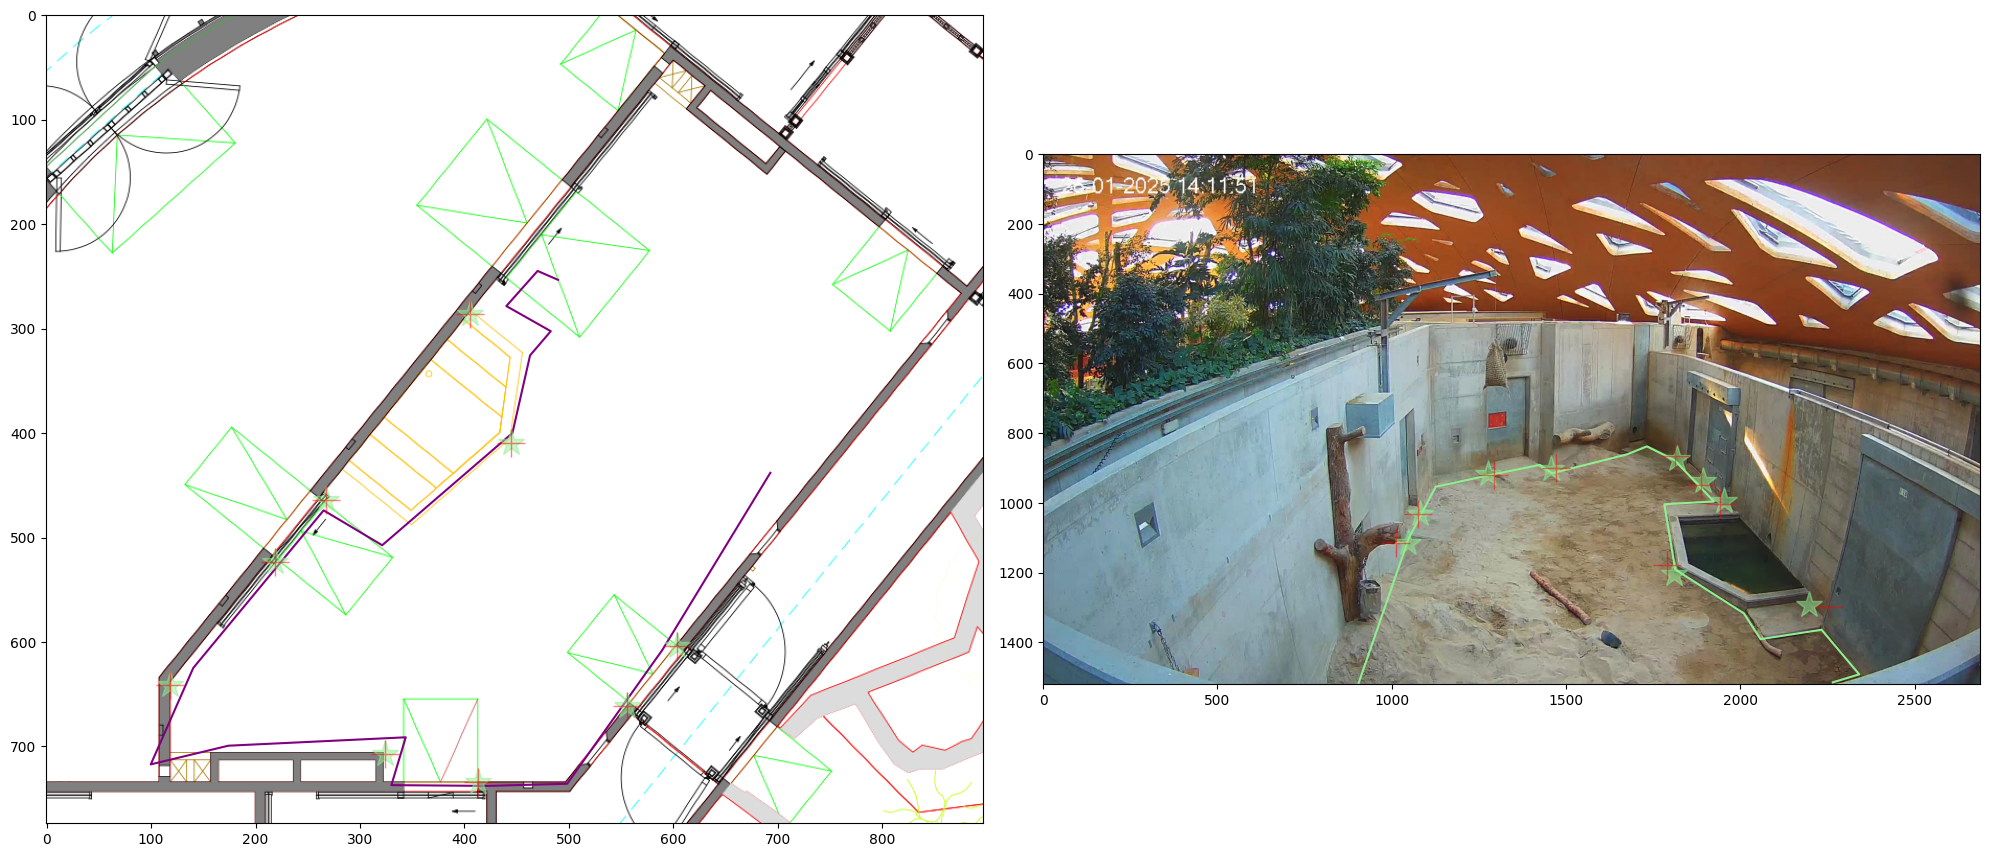

In [30]:
# Find homography through OpenCV
H_world2_from_camera,inliers=cv2.findHomography(constraint_points_in_image, constraint_points_in_world2)
H_camera_from_world2 = np.linalg.inv(H_world2_from_camera)


print(f"Inliners {inliers.sum()/len(inliers):.0%}")
print(f"H_world2_from_camera=\n{H_world2_from_camera}")
plot_projections(H_camera_from_world2)

# H_submap_from_camera = T_submap_from_world2 @ H_world2_from_camera
# H_camera_from_submap = np.linalg.inv(H_submap_from_camera)
# print(f"H_submap_from_camera=\n{H_submap_from_camera}")

# errors = np.mean(np.linalg.norm(constraint_points_in_submap - hmult(H_submap_from_camera, constraint_points_in_image), axis=1))
# print("Mean error (submap units): ", errors)

# errors = np.mean(np.linalg.norm(constraint_points_in_world2  - hmult(H_world2_from_camera, constraint_points_in_image), axis=1))
# print("Mean error (world units): ", errors)

# errors = np.mean(np.linalg.norm(constraint_points_in_image -  hmult(H_camera_from_world2, constraint_points_in_world2), axis=1))
# print("Mean error (camera units): ", errors)
